In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
TrainData = "/content/drive/My Drive/deepln/Face Mask Dataset/Train"
TestData = "/content/drive/My Drive/deepln/Face Mask Dataset/Test"
ValidationData = "/content/drive/My Drive/deepln/Face Mask Dataset/Validation"

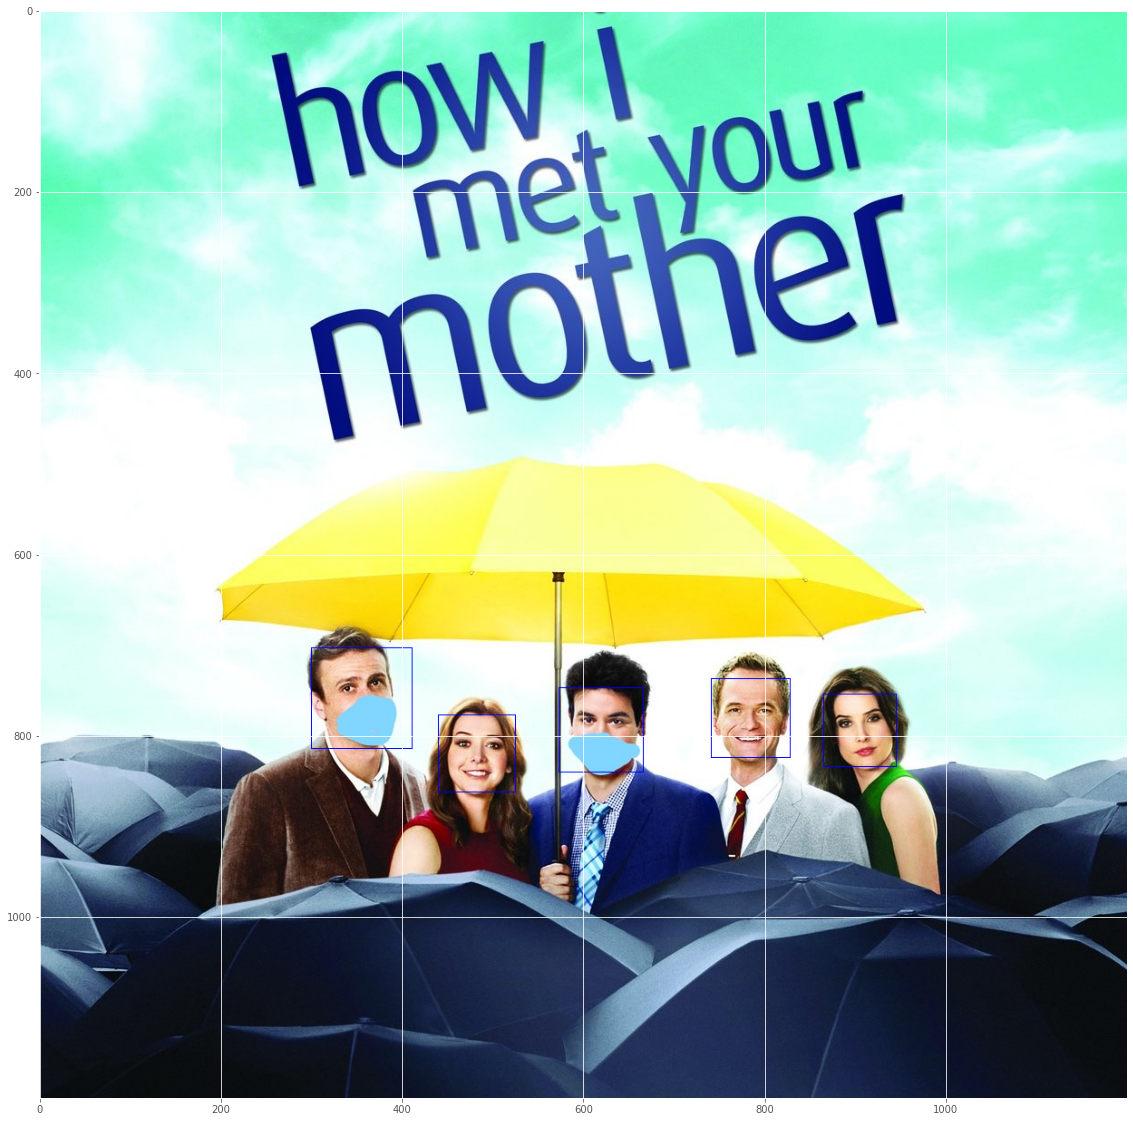

In [80]:
img = cv2.imread("/content/drive/My Drive/deepln/HIMYM2.jpg")
BGRim = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
FaceModel = cv2.CascadeClassifier("/content/drive/My Drive/deepln/haarcascade/haarcascade/haarcascade_frontalface_default.xml")
Faces = FaceModel.detectMultiScale(
    img, scaleFactor=1.08, minNeighbors=4
)  
for (x, y, w, h) in Faces:
    cv2.rectangle(BGRim, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.figure(figsize=(20, 20))
plt.imshow(BGRim)  

In [ ]:

imageDataGenerator = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.2, shear_range=0.2
)
TrainClass = imageDataGenerator.flow_from_directory(
    directory=TrainData, target_size=(128, 128), class_mode="categorical", batch_size=32
)


ValidationClass = imageDataGenerator.flow_from_directory(
    directory=ValidationData, target_size=(128, 128), class_mode="categorical", batch_size=32
)


TestClass = imageDataGenerator.flow_from_directory(
    directory=TestData, target_size=(128, 128), class_mode="categorical", batch_size=32
)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [ ]:
from keras.callbacks import TensorBoard

vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19_model)
model.add(Flatten())
model.add(Dense(2, activation="sigmoid"))
model.summary()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics="accuracy")
tensorboard=TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True)



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 16386     
                                                                 
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
from traitlets.traitlets import validate
EpochCount=20
model_history = model.fit_generator(
    generator=TrainClass,
    steps_per_epoch=len(TrainClass) // 32,
    epochs=EpochCount,
    validation_data=ValidationClass,
    validation_steps=len(ValidationClass) // 32,
    callbacks=[tensorboard],
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
9/9 [==============================] - 3s 271ms/step - loss: 0.7092 - accuracy: 0.5903
Epoch 2/20
9/9 [==============================] - 2s 221ms/step - loss: 0.2866 - accuracy: 0.9028
Epoch 3/20
9/9 [==============================] - 2s 221ms/step - loss: 0.1877 - accuracy: 0.9271
Epoch 4/20
9/9 [==============================] - 2s 219ms/step - loss: 0.1238 - accuracy: 0.9618
Epoch 5/20
9/9 [==============================] - 2s 217ms/step - loss: 0.1200 - accuracy: 0.9583
Epoch 6/20
9/9 [==============================] - 2s 215ms/step - loss: 0.1251 - accuracy: 0.9514
Epoch 7/20
9/9 [==============================] - 3s 293ms/step - loss: 0.0853 - accuracy: 0.9792
Epoch 8/20
9/9 [==============================] - 2s 218ms/step - loss: 0.1193 - accuracy: 0.9618
Epoch 9/20
9/9 [==============================] - 2s 219ms/step - loss: 0.0908 - accuracy: 0.9722
Epoch 10/20
9/9 [==============================] - 2s 221ms/step - loss: 0.0841 - accuracy: 0.9722
Epoch 11/20
9/9 [==

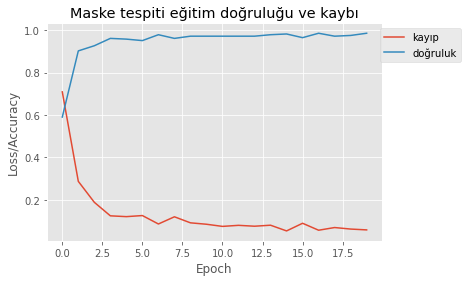

In [61]:
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, EpochCount), model_history.history["loss"], label="kayıp")
plt.plot(np.arange(0, EpochCount), model_history.history["accuracy"], label="doğruluk")
plt.title("Maske tespiti eğitim doğruluğu ve kaybı")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1))
plt.savefig("plot.png")




In [68]:

ModelKyp, ModelDgrlk = model.evaluate(TestClass)
print("Modelde %.2f%% 'lik kayıp  var."%(ModelKyp*100)) 
print("Doğruluk oranı %.2f%%" % ( ModelDgrlk*100))

31/31 [==============================] - 7s 211ms/step - loss: 0.0557 - accuracy: 0.9849
Modelde 5.57% 'lik kayıp  var.
Doğruluk oranı 98.49%


In [ ]:
model.save('/content/drive/My Drive/deepln/new_model.h5')
model.save('/content/drive/My Drive/deepln/new_model.tf')


model.save_weights('/content/drive/My Drive/deepln/newmodelweight.hdf5')


INFO:tensorflow:Assets written to: /content/drive/My Drive/deepln/new_model.tf/assets


In [ ]:

mask_det_label = {0: "MASKELI", 1: "MASKESIZ"}
mask_det_label_colour = {0: (0, 255, 0), 1: (255, 0, 0)}
pad_y = 1  

main_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  

for i in range(len(Faces)):
    (x, y, w, h) = Faces[i]
    cropped_face = main_img[y : y + h, x : x + w]
    cropped_face = cv2.resize(cropped_face, (128, 128))
    cropped_face = np.reshape(cropped_face, [1, 128, 128, 3]) / 255.0
    mask_result = model.predict(cropped_face)  
    print_label = mask_det_label[mask_result.argmax()] 
    label_colour = mask_det_label_colour[mask_result.argmax()] 

    
    (t_w, t_h), _ = cv2.getTextSize(
        print_label, cv2.FONT_HERSHEY_SIMPLEX, 1, 1
    )  
    
    cv2.rectangle(
        main_img,
        (x, y + pad_y),
        (x + t_w, y - t_h - pad_y - 6),
        label_colour,
        -1,
    )  

    cv2.putText(
        main_img,
        print_label,
        (x, y - 6),
        cv2.FONT_HERSHEY_DUPLEX,
      1,
        (255, 255, 255), 
        1,
    ) 

    cv2.rectangle(
        main_img,
        (x, y),
        (x + w, y + h),
        label_colour,
        5,
    )  

plt.figure(figsize=(30, 30))
plt.imshow(main_img)  